# Beacon Sync

Synchronise two delta peaks, by using an intermediate beacon that was sent out together with it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.fft as ft

In [2]:
# Monkey patch correlation_lags
if not hasattr(signal, 'correlation_lags'):
    def correlation_lags(in1_len, in2_len, mode='full'):
        r"""
        Calculates the lag / displacement indices array for 1D cross-correlation.
        Parameters
        ----------
        in1_size : int
            First input size.
        in2_size : int
            Second input size.
        mode : str {'full', 'valid', 'same'}, optional
            A string indicating the size of the output.
            See the documentation `correlate` for more information.
        See Also
        --------
        correlate : Compute the N-dimensional cross-correlation.
        Returns
        -------
        lags : array
            Returns an array containing cross-correlation lag/displacement indices.
            Indices can be indexed with the np.argmax of the correlation to return
            the lag/displacement.
        Notes
        -----
        Cross-correlation for continuous functions :math:`f` and :math:`g` is
        defined as:
        .. math::
            \left ( f\star g \right )\left ( \tau \right )
            \triangleq \int_{t_0}^{t_0 +T}
            \overline{f\left ( t \right )}g\left ( t+\tau \right )dt
        Where :math:`\tau` is defined as the displacement, also known as the lag.
        Cross correlation for discrete functions :math:`f` and :math:`g` is
        defined as:
        .. math::
            \left ( f\star g \right )\left [ n \right ]
            \triangleq \sum_{-\infty}^{\infty}
            \overline{f\left [ m \right ]}g\left [ m+n \right ]
        Where :math:`n` is the lag.
        Examples
        --------
        Cross-correlation of a signal with its time-delayed self.
        >>> from scipy import signal
        >>> from numpy.random import default_rng
        >>> rng = default_rng()
        >>> x = rng.standard_normal(1000)
        >>> y = np.concatenate([rng.standard_normal(100), x])
        >>> correlation = signal.correlate(x, y, mode="full")
        >>> lags = signal.correlation_lags(x.size, y.size, mode="full")
        >>> lag = lags[np.argmax(correlation)]
        """

        # calculate lag ranges in different modes of operation
        if mode == "full":
            # the output is the full discrete linear convolution
            # of the inputs. (Default)
            lags = np.arange(-in2_len + 1, in1_len)
        elif mode == "same":
            # the output is the same size as `in1`, centered
            # with respect to the 'full' output.
            # calculate the full output
            lags = np.arange(-in2_len + 1, in1_len)
            # determine the midpoint in the full output
            mid = lags.size // 2
            # determine lag_bound to be used with respect
            # to the midpoint
            lag_bound = in1_len // 2
            # calculate lag ranges for even and odd scenarios
            if in1_len % 2 == 0:
                lags = lags[(mid-lag_bound):(mid+lag_bound)]
            else:
                lags = lags[(mid-lag_bound):(mid+lag_bound)+1]
        elif mode == "valid":
            # the output consists only of those elements that do not
            # rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
            # must be at least as large as the other in every dimension.

            # the lag_bound will be either negative or positive
            # this let's us infer how to present the lag range
            lag_bound = in1_len - in2_len
            if lag_bound >= 0:
                lags = np.arange(lag_bound + 1)
            else:
                lags = np.arange(lag_bound, 1)
        return lags

    signal.correlation_lags = correlation_lags

In [3]:
### signal generation
def fft_bandpass(signal, band, samplerate):
    """
    Simple bandpassing function employing a FFT.

    Parameters
    ----------
    signal : arraylike
    band : tuple(low, high)
        Frequencies for bandpassing
    samplerate : float
    """
    signal = np.asarray(signal)

    fft = ft.rfft(signal)
    freqs = ft.rfftfreq(signal.size, 1/samplerate)
    fft[(freqs < band[0]) | (freqs > band[1])] = 0
    
    return ft.irfft(fft, signal.size), (fft, freqs)

def deltapeak(timelength=1e3, samplerate=1, offset=None, peaklength=1):
    N_samples = int(timelength * samplerate)
    if offset is None:
        offset = (np.random.random(1)*N_samples).astype(int) % N_samples
    elif isinstance(offset, (tuple, list)):
        offset_min = offset[0]
        offset_max = offset[-1]
        
        offset = (np.random.random(1)*(offset_max - offset_min)+offset_min).astype(int) % N_samples
    
    position = (offset + np.arange(0, peaklength)).astype(int) % N_samples
    
    signal = np.zeros(N_samples)
    signal[position] = 1
    
    return signal, position

def sin_delay(f, t, t_delay=0, phase=0):
    return np.sin(2*np.pi*f * (t + t_delay) + phase)

def annotate_width(ax, name, x1, x2, y, text_kw={}, arrow_kw={}):
    default_arrow_kw = dict(
            xy = (x1, y),
            xytext = (x2,y),
            arrowprops = dict(
                arrowstyle="<->",
                shrinkA=False,
                shrinkB=False
            ),
    )

    default_text_kw = dict(
            va='bottom',
            ha='center',
            xy=((x1+x2)/2, y)
    )

    an1 = ax.annotate("", **{**default_arrow_kw, **arrow_kw})
    an2 = ax.annotate(name, **{**default_text_kw, **text_kw})

    return [an1, an2]

def time2phase(time, frequency=1):
    return 2*np.pi*frequency*time

def phase2time(phase, frequency=1):
    return phase/(2*np.pi*frequency)

def time_roll(a, samplerate, time_shift, *roll_args, **roll_kwargs):
    """
    Like np.roll, but use samplerate and time_shift to approximate
    the offset to roll.
    """
    shift = np.rint(time_shift*samplerate).astype(int)
    return np.roll(a, shift, *roll_args, **roll_kwargs)

In [4]:
us = 1e3 # ns
ns = 1/us # us


band = (30, 80) # MHz
samplerate = 5000 # MHz
timelength = 0.2 # us

time = np.arange(0, timelength, 1/samplerate)

# generate beacons
if True: # in-band
    f_beacon = 70 # MHz
else: # under band
    f_beacon = 20 # MHz

beacon_amplitude = 0.1
beacon_init_phase = time2phase(4.4*ns, f_beacon)
beacon_phase_offset = 1.2*np.pi

beacons = np.array([
    beacon_amplitude * sin_delay(f_beacon, time, t_delay=0, phase=-beacon_init_phase),
    beacon_amplitude * sin_delay(f_beacon, time, t_delay=0, phase=-beacon_init_phase-beacon_phase_offset)
])


# generate impulses
impulses = []
impulses_offsets = []
impulses_def_offsets = [
                        (0.3*len(time),0.4*len(time)),
                        (0.7*len(time),0.8*len(time)),
                       ]# random offsets in interval
for i in range(2):
    offset = None
    if impulses_def_offsets:
        if len(impulses_def_offsets) == 1:
            offset = impulses_def_offsets[0]
        else:
            offset = impulses_def_offsets[i]
    orig_imp, imp_offset = deltapeak(timelength, samplerate, offset=offset, peaklength=1)

    ## Bandpass it
    imp, _ = fft_bandpass(orig_imp, band, samplerate)
    imp /= np.max(imp)
    
    impulses.append(imp)
    impulses_offsets.append(imp_offset/samplerate)

impulses = np.array(impulses)
impulses_offsets = np.array(impulses_offsets)
print("Beacon period [ns]:", 1/f_beacon/ns)
print("Beacon initial [ns]:", phase2time(beacon_init_phase, f_beacon) /ns)
print("Beacon initial [phase]:", beacon_init_phase)
print("Beacon initial [idx]:", phase2time(beacon_init_phase, f_beacon)*samplerate)
print("Beacon difference [ns]:", phase2time(beacon_phase_offset, f_beacon)/ns)
print("Beacon difference [phase]:", beacon_phase_offset)
print("Impulse offsets [ns]:", impulses_offsets[:,0]/ns)
print("Time difference Impulses [ns]: {}".format( (impulses_offsets[1,0]-impulses_offsets[0,0])/ns ))

Beacon period [ns]: 14.285714285714285
Beacon initial [ns]: 4.4
Beacon initial [phase]: 1.9352210746113125
Beacon initial [idx]: 22.0
Beacon difference [ns]: 8.571428571428571
Beacon difference [phase]: 3.7699111843077517
Impulse offsets [ns]: [ 75.4 149.6]
Time difference Impulses [ns]: 74.20000000000002


In [5]:
full_signals = impulses + beacons

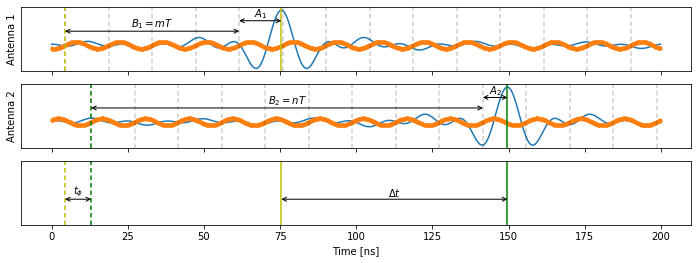

In [6]:
# Make a figure showing two signals with a beacon per signal
colors = ['y','g']
multiplier_name = ['m','n']


fig, axes = plt.subplots(3,1, sharex=True, figsize=(12,4))
axes[-1].set_xlabel("Time [ns]")
axes[-1].set_yticks([],[])
for i in range(0, 2):
    axes[i].set_yticks([],[])
    axes[i].set_ylabel("Antenna {:d}".format(i+1))
    axes[i].plot(time/ns, impulses[i])
    axes[i].plot(time/ns, beacons[i], marker='.')
    if not True:
        axes[i].plot(time/ns, full_signals[i])


# indicate timing of pulses
for i, impulse_offset in enumerate(impulses_offsets):
    kwargs = dict(color=colors[i])
    [ax.axvline(impulse_offset/ns, **kwargs) for ax in (axes[i], axes[-1])]


# indicate timing of the beacons
# and annotate ticks and impulse widths
tmp_beacon_phases = beacon_init_phase + np.arange(0,2)*beacon_phase_offset
if not True: # mod phases
    tmp_beacon_phases %= 2*np.pi
tmp_beacon_offsets = phase2time(tmp_beacon_phases, f_beacon)


A = np.empty(2)
B = np.empty(2)
for i in range(0,2):
    kwargs = dict(color=colors[i], ls=(0, (3,2)))
    tick_kwargs = dict(color='k', alpha=0.2)

    # indicate every period of the beacon
    beacon_ticks =  tmp_beacon_offsets[i] + [(n)*1/f_beacon for n in range(1+int((time[-1] - time[0]) * f_beacon))]

    [axes[i].axvline(tick/ns, **{**kwargs, **tick_kwargs}) for tick in beacon_ticks]

    # reference period in beacon
    [ax.axvline(tmp_beacon_offsets[i]/ns, **kwargs) for ax in (axes[i], axes[-1])]

    # annotate width between impulse and closest beacon tick
    # and closest beacon tick and reference tick
    closest_beacon_tick_id = np.argmin(np.abs(beacon_ticks-impulses_offsets[i]))
    if closest_beacon_tick_id != 0 and beacon_ticks[closest_beacon_tick_id] > impulses_offsets[i]:
        closest_beacon_tick_id -= 1
    closest_beacon_tick = beacon_ticks[closest_beacon_tick_id]

    annotate_width(axes[i], f"$A_{i+1}$", closest_beacon_tick/ns, impulses_offsets[i]/ns, 0.7)
    annotate_width(axes[i], f"$B_{i+1}={multiplier_name[i]}T$", closest_beacon_tick/ns, tmp_beacon_offsets[i]/ns, 0.4)

    A[i] = closest_beacon_tick - impulses_offsets[i]
    B[i] = closest_beacon_tick - tmp_beacon_offsets[i]

# annotate width between beacon reference periods
annotate_width(axes[-1], "$t_\phi$", tmp_beacon_offsets[0]/ns, tmp_beacon_offsets[-1]/ns, 0.4)

# annotate width between pulses
annotate_width(axes[-1], "$\Delta t$", impulses_offsets[0]/ns, impulses_offsets[-1]/ns, 0.4)


fig.show()
if False:
    fig.savefig('figures/08_beacon_sync_timing_outline.pdf')

In [7]:
t_phi = (tmp_beacon_offsets[1]-tmp_beacon_offsets[0])
Delta_A = (A[1] - A[0])

print("\Delta t = {}ns".format( (impulses_offsets[1][0] - impulses_offsets[0][0])/ns ))
print("\Delta A = {}ns".format( Delta_A/ns ))
print("t_phi = {}ns".format( t_phi/ns ))
print("B_1 = {}ns = {}T".format( (B[0])/ns, (B[0]*f_beacon) ))
print("B_2 = {}ns = {}T".format( (B[1])/ns, (B[1]*f_beacon) ))
print("kT = {}ns = {}T".format( (B[1]-B[0])/ns, (B[1]-B[0])*f_beacon ))



\Delta t = 74.20000000000002ns
\Delta A = 5.7999999999999785ns
t_phi = 8.571428571428573ns
B_1 = 57.14285714285714ns = 4.0T
B_2 = 128.57142857142856ns = 9.0T
kT = 71.42857142857142ns = 5.0T


$
\Delta t = (A_2 + B_2) - (A_1 + B_1) + t_\phi\\
\quad         = (A_2 - A_1) + (B_2 - B_1) + t_\phi\\
\quad         = (A_2 - A_1) + (nT - mT) + t_\phi\\
\quad         = \Delta A + (kT) + t_\phi
$

, where $\Delta A < T$ and $k \in \mathbb{Z}$ and $t_\phi$ is minimisable.

Then $\Delta t$ can be determined by iteratively summing the signals, changing $k$, and finding the $k$ belonging to the maximum of the sums.

In [8]:
def find_best_integer_periods_sum(samplerate, f_beacon, ref_impulse, impulse, k_step=1):
    max_k = int( len(ref_impulse)*f_beacon/samplerate )
    ks = np.arange(-max_k/2, max_k/2, step=k_step)
    
    maxima = np.empty(len(ks))
    
    best_i = 0
    
    for i,k in enumerate(ks, 0):
        augmented_impulse = time_roll(impulse, samplerate, k/f_beacon)
        
        maxima[i] = max(ref_impulse + augmented_impulse)
        
        if maxima[i] > maxima[best_i]:
            best_i = i
        
    return ks[best_i], (ks, maxima)

Best k: -5
Maximum: 2.0


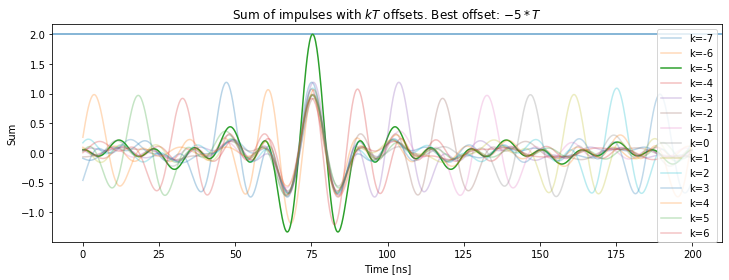

In [9]:
# Make figure showing the sums depending on k
ref_impulse = impulses[0]
my_impulse = impulses[1]

# remove 'already determined' offsets
if True:
    # $t_\phi$ offset
    my_impulse = time_roll(my_impulse, samplerate, -t_phi)

    # $\Delta A$ offset
    my_impulse = time_roll(my_impulse, samplerate, Delta_A)

best_k, (ks, maxima) = find_best_integer_periods_sum(samplerate, f_beacon, ref_impulse, my_impulse)
print("Best k: {:0g}".format(best_k))
print("Maximum: {}".format(maxima[np.where(ks == best_k)][0]))


# Make figure
fig, axes = plt.subplots(1, 1, sharex=True,figsize=(12,4))
if not hasattr(axes, 'ndim'):
    axes = [axes]

axes[0].set_title("Sum of impulses with $kT$ offsets. Best offset: ${:.0f}*T$".format(best_k))
axes[-1].set_xlabel("Time [ns]")

if not True:
    i=0
    axes[i].set_ylabel("Reference")
    axes[i].plot(time/ns, ref_impulse, label="reference")
    axes[i].plot(time/ns, my_impulse, label='impulse')
    axes[i].legend()

axes[-1].set_ylabel("Sum")

best_maximum = np.max(maxima)
axes[-1].axhline(best_maximum, alpha=0.7)

for i, k in enumerate(ks, 0):
        sample_offset = int(k*1/f_beacon*samplerate)
        augmented_impulses = np.roll(my_impulse, sample_offset)
        
        summed_impulse = ref_impulse + augmented_impulses
        if True or k%2 == 1:
            axes[-1].plot(time/ns, summed_impulse, label='k={:.0f}'.format(k),
                         alpha=0.1 + 0.9*1/(1+4*abs(best_maximum-maxima[i]))
                        )
    
axes[-1].legend()
fig.show()

del ref_impulse
del my_impulse

## 1. Solve it

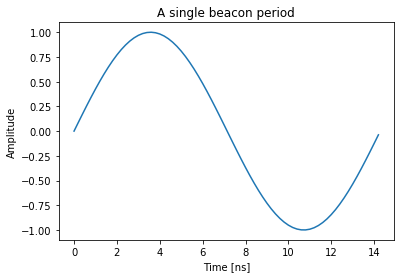

In [10]:
# single out one period of the beacon
beacon_samplerate = samplerate # MHz
beacon_time = np.arange(0, 1/f_beacon, 1/beacon_samplerate)
ref_beacon = sin_delay(f_beacon, beacon_time, phase=0, t_delay=0)

# .. and show beacon period
fig, ax = plt.subplots()
ax.set_title("A single beacon period")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Amplitude")
ax.plot(beacon_time/ns,ref_beacon)
fig.show()

In [11]:
### correlation
def correlation_and_lag(sig1, sig2, mode="full", normalise=False):
    corr = signal.correlate(sig1, sig2, mode=mode)
    if normalise:
        corr /= np.max(corr)

    lags = signal.correlation_lags(sig1.size, sig2.size, mode=mode)
    
    return corr, lags

def find_best_lag(sig1, sig2, fix_one_short=False, fix_positive=False, subtract_means=True, **corr_kwargs):
    if subtract_means:
        sig1 -= np.mean(sig1)
        sig2 -= np.mean(sig2)
    
    corr, lags = correlation_and_lag(sig1, sig2, **corr_kwargs)
    lag_id = corr.argmax()

    lag = lags[lag_id]
    
    if fix_one_short:
        # for some reason it is always one short
        if lag > 0:
            lag += 1
        elif lag < 0:
            lag -= 1

    # turn negative lag into positive
    if fix_positive and lag < 0:
            lag += len(sig2)
    
    return lag, (corr, lags)

def find_beacon_phase_delay(samplerate, f_beacon, reference_beacon, delayed_beacon, **lag_kwargs):
    """
    Return phase delay of `beacon` with respect to `reference_beacon`.
    Note that the returned value can be off by a multiple of $2\pi$.
    
    Parameters
    ==========
    samplerate : float
        Samplerate of both reference_beacon and delayed_beacon
    f_beacon : float
        Frequency of the beacons
    reference_beacon : ndarray
        The beacon to use as a reference
    beacon : ndarray
        The beacon to find the delay for
    """
    
    calc_lag, _ = find_best_lag(reference_beacon, delayed_beacon, **lag_kwargs)
    
    time = calc_lag / samplerate
    
    return 2*np.pi* f_beacon * time

#####  1.1 Beacon Phase Delays

In [12]:
beacon_phase_delays = np.array([
    find_beacon_phase_delay(beacon_samplerate, f_beacon, beacons[0], beacon)
        for beacon in beacons
])

beacon_time_delays = phase2time(beacon_phase_delays, f_beacon)

print("Beacon delays [ns] \pm k*{}ns: {}".format(1/f_beacon/ns, beacon_time_delays/ns))

Beacon delays [ns] \pm k*14.285714285714285ns: [0.  5.6]


0 0.0
1 2.463008640414398


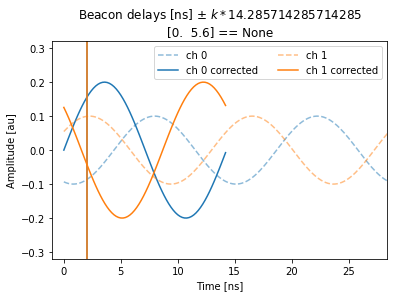

In [13]:
# Make a figure showing the corrected beacons
fig, ax = plt.subplots(1,1, sharex=True)
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Amplitude [au]")
ax.set_title("Beacon delays [ns] $\pm$ $k*{}$\n{} == {}".format(1/f_beacon/ns, beacon_time_delays/ns, None))

for i, _ in enumerate(beacons):
    l = ax.plot(time/ns, beacons[i], label="ch {}".format(i), ls ='--', alpha=0.5)
    
    print(i, beacon_phase_delays[i], )

    if True:
        corrected_beacon = sin_delay(f_beacon, beacon_time, phase=beacon_phase_delays[i], t_delay=0)
    else:
        corrected_beacon = sin_delay(f_beacon, beacon_time, t_delay=beacon_time_delays[i], phase=0)
        
    ax.plot(beacon_time/ns, 2*beacon_amplitude*corrected_beacon, label='ch {} corrected'.format(i), color=l[0].get_color())
    
    # indicate start of uncorrected beacons
    ax.axvline(phase2time((2*np.pi+beacon_time_delays[i])%2*np.pi, f_beacon)/ns, color=l[0].get_color())

ax.legend(ncol=2)
ax.margins(y=0.3)
if True:
    ax.set_xlim(time[0]/ns - 1, time[2*samplerate//f_beacon]/ns)

fig.show()


#ax.plot((double_signal_time) * ns, signal_2(double_signal_time + calc_shift), 'r--', label='Recovered')

##### 1.2 Impulse vs beacon delays

Find the delay within a single beacon period

In [14]:
#def find_beacon_impulse_delay(samplerate, f_beacon, impulse, init_phase=0):
def find_beacon_impulse_phase_delay(samplerate, f_beacon, reference_beacon, impulse, **lag_kwargs):
    """
    Return phase delay of `beacon` with respect to `reference_beacon`.
    Note that the returned value can be off by a multiple of $2\pi$.
    
    Parameters
    ==========
    samplerate : float
        Samplerate of both reference_beacon and delayed_beacon
    f_beacon : float
        Frequency of the beacons
    reference_beacon : ndarray
        The beacon to use as a reference
    beacon : ndarray
        The beacon to find the delay for
    """
    
    calc_lag, _ = find_best_lag(reference_beacon, impulse, **lag_kwargs)
    
    return 2*np.pi* f_beacon * calc_lag / samplerate

In [15]:
impulse_beacon_phase_delays = np.empty( len(impulses) )

for i, _ in enumerate(impulses):
    impulse_beacon_phase_delays[i] = find_beacon_impulse_phase_delay(
        beacon_samplerate, f_beacon, 
        ref_beacon, impulses[i]
    )

print("Beacon Impuls delays: ${}$ns".format(impulse_beacon_phase_delays/f_beacon/ns))

Beacon Impuls delays: $[-454.90261624 -921.11496603]$ns


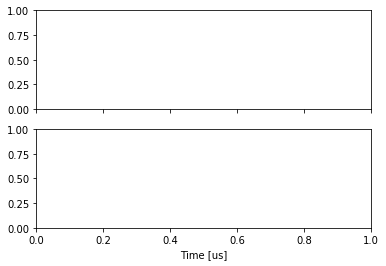

In [16]:
# Make a figure showing the corrected beacons
fig, axes = plt.subplots(len(impulses),1, sharex=True)
axes[-1].set_xlabel("Time [us]")
ax.set_title("Beacon Impuls delays: ${}$ns".format(impulse_beacon_phase_delays/f_beacon/ns))

for i, beacon in enumerate(beacons):
    ax.set_ylabel("Amplitude [au]")
    ax.plot(time, beacon, label="ch {}".format(i))

ax.plot(beacon_time, corrected_beacon, label='phase corrected (overlaps ch 0)')

ax.legend()

fig.show()